# Fast tokenizers in the QA pipeline (PyTorch)

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]

We will now dive into the question-answering pipeline and see how to leverage the offsets to grab the answer to the question at hand from the context, a bit like we did for the grouped entities in the previous section. Then we will see how we can deal with very long contexts that end up being truncated. You can skip this section if you’re not interested in the question answering task.

In [1]:
from IPython.display import HTML

HTML('<iframe width="430" height="320" src="https://www.youtube.com/embed/_wxyB3j3mk4" title="Inside the Question answering pipeline (PyTorch)" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

/home/hpshin/.local/lib/python3.6/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## Using the question-answering pipeline

As we saw in [Chapter 1](https://huggingface.co/course/chapter1), we can use the question-answering pipeline like this to get the answer to a question:

In [ ]:
from transformers import pipeline

question_answerer = pipeline("question-answering")
context = """
🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch, and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""
question = "Which deep learning libraries back 🤗 Transformers?"
question_answerer(question=question, context=context)

{'score': 0.97773,
 'start': 78,
 'end': 105,
 'answer': 'Jax, PyTorch and TensorFlow'}

Unlike the other pipelines, which can’t truncate and split texts that are longer than the maximum length accepted by the model (and thus may miss information at the end of a document), this pipeline can deal with very long contexts and will return the answer to the question even if it’s at the end:

In [ ]:
long_context = """
🤗 Transformers: State of the Art NLP

🤗 Transformers provides thousands of pretrained models to perform tasks on texts such as classification, information extraction,
question answering, summarization, translation, text generation and more in over 100 languages.
Its aim is to make cutting-edge NLP easier to use for everyone.

🤗 Transformers provides APIs to quickly download and use those pretrained models on a given text, fine-tune them on your own datasets and
then share them with the community on our model hub. At the same time, each python module defining an architecture is fully standalone and
can be modified to enable quick research experiments.

Why should I use transformers?

1. Easy-to-use state-of-the-art models:
  - High performance on NLU and NLG tasks.
  - Low barrier to entry for educators and practitioners.
  - Few user-facing abstractions with just three classes to learn.
  - A unified API for using all our pretrained models.
  - Lower compute costs, smaller carbon footprint:

2. Researchers can share trained models instead of always retraining.
  - Practitioners can reduce compute time and production costs.
  - Dozens of architectures with over 10,000 pretrained models, some in more than 100 languages.

3. Choose the right framework for every part of a model's lifetime:
  - Train state-of-the-art models in 3 lines of code.
  - Move a single model between TF2.0/PyTorch frameworks at will.
  - Seamlessly pick the right framework for training, evaluation and production.

4. Easily customize a model or an example to your needs:
  - We provide examples for each architecture to reproduce the results published by its original authors.
  - Model internals are exposed as consistently as possible.
  - Model files can be used independently of the library for quick experiments.

🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""
question_answerer(question=question, context=long_context)

{'score': 0.97149,
 'start': 1892,
 'end': 1919,
 'answer': 'Jax, PyTorch and TensorFlow'}

Let’s see how it does all of this!

## Using a model for question answering

Like with any other pipeline, we start by tokenizing our input and then send it through the model. The checkpoint used by default for the question-answering pipeline is **[distilbert-base-cased-distilled-squad](https://huggingface.co/distilbert-base-cased-distilled-squad)** (the “squad” in the name comes from the dataset on which the model was fine-tuned; we’ll talk more about the SQuAD dataset in [Chapter 7](https://huggingface.co/course/chapter7/7)):

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

model_checkpoint = "distilbert-base-cased-distilled-squad"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

inputs = tokenizer(question, context, return_tensors="pt")
outputs = model(**inputs)

Note that we tokenize the question and the context as a pair, with the question first.

<img src="https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter6/question_tokens.svg" width="90%">


Models for question answering work a little differently from the models we’ve seen up to now. Using the picture above as an example, the model has been trained to predict the index of the token starting the answer (here 21) and the index of the token where the answer ends (here 24). This is why those models don’t return one tensor of logits but two: one for the logits corresponding to the start token of the answer, and one for the logits corresponding to the end token of the answer. Since in this case we have only one input containing 66 tokens, we get:

In [ ]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits
print(start_logits.shape, end_logits.shape)

torch.Size([1, 66]) torch.Size([1, 66])

To convert those logits into probabilities, we will apply a softmax function — but before that, we need to make sure we mask the indices that are not part of the context. Our input is [CLS] question [SEP] context [SEP], so we need to mask the tokens of the question as well as the [SEP] token. We’ll keep the [CLS] token, however, as some models use it to indicate that the answer is not in the context.

Since we will apply a softmax afterward, we just need to replace the logits we want to mask with a large negative number. Here, we use -10000:

In [ ]:
import torch

sequence_ids = inputs.sequence_ids()
# Mask everything apart from the tokens of the context
mask = [i != 1 for i in sequence_ids]
# Unmask the [CLS] token
mask[0] = False
mask = torch.tensor(mask)[None]

start_logits[mask] = -10000
end_logits[mask] = -10000

Now that we have properly masked the logits corresponding to positions we don’t want to predict, we can apply the softmax:

In [ ]:
start_probabilities = torch.nn.functional.softmax(start_logits, dim=-1)[0]
end_probabilities = torch.nn.functional.softmax(end_logits, dim=-1)[0]

At this stage, we could take the argmax of the start and end probabilities — but we might end up with a start index that is greater than the end index, so we need to take a few more precautions. We will compute the probabilities of each possible start_index and end_index where start_index <= end_index, then take the tuple (start_index, end_index) with the highest probability.

Assuming the events “The answer starts at start_index” and “The answer ends at end_index” to be independent, the probability that the answer starts at start_index and ends at end_index is:

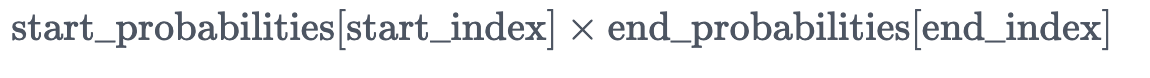

So, to compute all the scores, we just need to compute all the products 


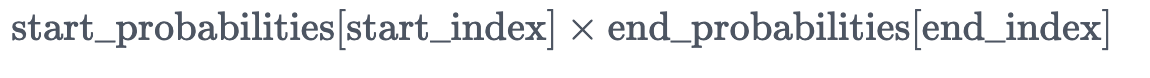

where start_index <= end_index.

First let’s compute all the possible products:


In [ ]:
scores = start_probabilities[:, None] * end_probabilities[None, :]

Then we’ll mask the values where start_index > end_index by setting them to 0 (the other probabilities are all positive numbers). The torch.triu() function returns the upper triangular part of the 2D tensor passed as an argument, so it will do that masking for us:

In [ ]:
scores = torch.triu(scores)

Now we just have to get the index of the maximum. Since PyTorch will return the index in the flattened tensor, we need to use the floor division // and modulus % operations to get the start_index and end_index:

In [ ]:
max_index = scores.argmax().item()
start_index = max_index // scores.shape[1]
end_index = max_index % scores.shape[1]
print(scores[start_index, end_index])

0.97773

We’re not quite done yet, but at least we already have the correct score for the answer (you can check this by comparing it to the first result in the previous section):

✏️ Try it out! Compute the start and end indices for the five most likely answers.

We have the start_index and end_index of the answer in terms of tokens, so now we just need to convert to the character indices in the context. This is where the offsets will be super useful. We can grab them and use them like we did in the token classification task:

In [ ]:
inputs_with_offsets = tokenizer(question, context, return_offsets_mapping=True)
offsets = inputs_with_offsets["offset_mapping"]

start_char, _ = offsets[start_index]
_, end_char = offsets[end_index]
answer = context[start_char:end_char]

Now we just have to format everything to get our result:

In [ ]:
result = {
    "answer": answer,
    "start": start_char,
    "end": end_char,
    "score": scores[start_index, end_index],
}
print(result)

{'answer': 'Jax, PyTorch and TensorFlow',
 'start': 78,
 'end': 105,
 'score': 0.97773}

Great! That’s the same as in our first example!

✏️ Try it out! Use the best scores you computed earlier to show the five most likely answers. To check your results, go back to the first pipeline and pass in top_k=5 when calling it.

## Handling long contexts

If we try to tokenize the question and long context we used as an example previously, we’ll get a number of tokens higher than the maximum length used in the question-answering pipeline (which is 384):

In [ ]:
inputs = tokenizer(question, long_context)
print(len(inputs["input_ids"]))

461

So, we’ll need to truncate our inputs at that maximum length. There are several ways we can do this, but we don’t want to truncate the question, only the context. Since the context is the second sentence, we’ll use the "only_second" truncation strategy. The problem that arises then is that the answer to the question may not be in the truncated context. Here, for instance, we picked a question where the answer is toward the end of the context, and when we truncate it that answer is not present:

In [ ]:
inputs = tokenizer(question, long_context, max_length=384, truncation="only_second")
print(tokenizer.decode(inputs["input_ids"]))

"""
[CLS] Which deep learning libraries back [UNK] Transformers? [SEP] [UNK] Transformers : State of the Art NLP

[UNK] Transformers provides thousands of pretrained models to perform tasks on texts such as classification, information extraction,
question answering, summarization, translation, text generation and more in over 100 languages.
Its aim is to make cutting-edge NLP easier to use for everyone.

[UNK] Transformers provides APIs to quickly download and use those pretrained models on a given text, fine-tune them on your own datasets and
then share them with the community on our model hub. At the same time, each python module defining an architecture is fully standalone and
can be modified to enable quick research experiments.

Why should I use transformers?

1. Easy-to-use state-of-the-art models:
  - High performance on NLU and NLG tasks.
  - Low barrier to entry for educators and practitioners.
  - Few user-facing abstractions with just three classes to learn.
  - A unified AP

This means the model will have a hard time picking the correct answer. To fix this, the question-answering pipeline allows us to split the context into smaller chunks, specifying the maximum length. To make sure we don’t split the context at exactly the wrong place to make it possible to find the answer, it also includes some overlap between the chunks.

We can have the tokenizer (fast or slow) do this for us by adding **return_overflowing_tokens=True**, and we can specify the overlap we want with the stride argument. Here is an example, using a smaller sentence:

In [ ]:
sentence = "This sentence is not too long but we are going to split it anyway."
inputs = tokenizer(
    sentence, truncation=True, return_overflowing_tokens=True, max_length=6, stride=2
)

for ids in inputs["input_ids"]:
    print(tokenizer.decode(ids))

'[CLS] This sentence is not [SEP]'
'[CLS] is not too long [SEP]'
'[CLS] too long but we [SEP]'
'[CLS] but we are going [SEP]'
'[CLS] are going to split [SEP]'
'[CLS] to split it anyway [SEP]'
'[CLS] it anyway. [SEP]'

As we can see, the sentence has been split into chunks in such a way that each entry in inputs["input_ids"] has at most 6 tokens (we would need to add padding to have the last entry be the same size as the others) and there is an overlap of 2 tokens between each of the entries.

Let’s take a closer look at the result of the tokenization:

In [ ]:
print(inputs.keys())

dict_keys(['input_ids', 'attention_mask', 'overflow_to_sample_mapping'])

As expected, we get input IDs and an attention mask. The last key, overflow_to_sample_mapping, is a map that tells us which sentence each of the results corresponds to — here we have 7 results that all come from the (only) sentence we passed the tokenizer:

In [ ]:
print(inputs["overflow_to_sample_mapping"])

[0, 0, 0, 0, 0, 0, 0]

This is more useful when we tokenize several sentences together. For instance, this:

In [ ]:
sentences = [
    "This sentence is not too long but we are going to split it anyway.",
    "This sentence is shorter but will still get split.",
]
inputs = tokenizer(
    sentences, truncation=True, return_overflowing_tokens=True, max_length=6, stride=2
)

print(inputs["overflow_to_sample_mapping"])

[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]

which means the first sentence is split into 7 chunks as before, and the next 4 chunks come from the second sentence.

Now let’s go back to our long context. By default the question-answering pipeline uses a maximum length of 384, as we mentioned earlier, and a stride of 128, which correspond to the way the model was fine-tuned (you can adjust those parameters by passing max_seq_len and stride arguments when calling the pipeline). We will thus use those parameters when tokenizing. We’ll also add padding (to have samples of the same length, so we can build tensors) as well as ask for the offsets:

In [ ]:
inputs = tokenizer(
    question,
    long_context,
    stride=128,
    max_length=384,
    padding="longest",
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)

Those inputs will contain the input IDs and attention masks the model expects, as well as the offsets and the overflow_to_sample_mapping we just talked about. Since those two are not parameters used by the model, we’ll pop them out of the inputs (and we won’t store the map, since it’s not useful here) before converting it to a tensor:

In [ ]:
_ = inputs.pop("overflow_to_sample_mapping")
offsets = inputs.pop("offset_mapping")

inputs = inputs.convert_to_tensors("pt")
print(inputs["input_ids"].shape)

torch.Size([2, 384])

Our long context was split in two, which means that after it goes through our model, we will have two sets of start and end logits:

In [ ]:
outputs = model(**inputs)

start_logits = outputs.start_logits
end_logits = outputs.end_logits
print(start_logits.shape, end_logits.shape)

torch.Size([2, 384]) torch.Size([2, 384])

Like before, we first mask the tokens that are not part of the context before taking the softmax. We also mask all the padding tokens (as flagged by the attention mask):

In [ ]:
sequence_ids = inputs.sequence_ids()
# Mask everything apart from the tokens of the context
mask = [i != 1 for i in sequence_ids]
# Unmask the [CLS] token
mask[0] = False
# Mask all the [PAD] tokens
mask = torch.logical_or(torch.tensor(mask)[None], (inputs["attention_mask"] == 0))

start_logits[mask] = -10000
end_logits[mask] = -10000

Then we can use the softmax to convert our logits to probabilities:

In [ ]:
start_probabilities = torch.nn.functional.softmax(start_logits, dim=-1)
end_probabilities = torch.nn.functional.softmax(end_logits, dim=-1)

In [ ]:
candidates = []
for start_probs, end_probs in zip(start_probabilities, end_probabilities):
    scores = start_probs[:, None] * end_probs[None, :]
    idx = torch.triu(scores).argmax().item()

    start_idx = idx // scores.shape[1]
    end_idx = idx % scores.shape[1]
    score = scores[start_idx, end_idx].item()
    candidates.append((start_idx, end_idx, score))

print(candidates)

[(0, 18, 0.33867), (173, 184, 0.97149)]

Those two candidates correspond to the best answers the model was able to find in each chunk. The model is way more confident the right answer is in the second part (which is a good sign!). Now we just have to map those two token spans to spans of characters in the context (we only need to map the second one to have our answer, but it’s interesting to see what the model has picked in the first chunk).

✏️ Try it out! Adapt the code above to return the scores and spans for the five most likely answers (in total, not per chunk).

In [ ]:
for candidate, offset in zip(candidates, offsets):
    start_token, end_token, score = candidate
    start_char, _ = offset[start_token]
    _, end_char = offset[end_token]
    answer = long_context[start_char:end_char]
    result = {"answer": answer, "start": start_char, "end": end_char, "score": score}
    print(result)

{'answer': '\n🤗 Transformers: State of the Art NLP', 'start': 0, 'end': 37, 'score': 0.33867}
{'answer': 'Jax, PyTorch and TensorFlow', 'start': 1892, 'end': 1919, 'score': 0.97149}

If we ignore the first result, we get the same result as our pipeline for this long context — yay

✏️ Try it out! Use the best scores you computed before to show the five most likely answers (for the whole context, not each chunk). To check your results, go back to the first pipeline and pass in top_k=5 when calling it.

This concludes our deep dive into the tokenizer’s capabilities. We will put all of this in practice again in the next chapter, when we show you how to fine-tune a model on a range of common NLP tasks.